In [94]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sb

import sys #only needed to determine the python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting (notebook plotting )
%matplotlib inline
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
Pandas version 0.20.3
Matplotlib version 2.0.2


Utility Functions

These utility functions are not important to understanding the fbprophet module.  These are just some functions that will be used later.

In [95]:
# Static Utility Functions

def make_prophet_df(y_series):
    num_rows = len(y_series.index)
    c1 = y_series.index
    c2 = y_series.values
    col_data = np.array([c1, c2]).T
    col_names = ['ds', 'y']
    df = pd.DataFrame(index=range(num_rows), data=col_data, columns=col_names)
    return df

def last_df_date(df):
    if not df.index.is_all_dates:
        print("Input dataframe must have date indices.  Returning NaT")
        return pd.to_datetime('')

    df_reduced = df.dropna(axis=0, how='all')
    return df_reduced.index[-1].floor('1D')

def last_df_day(df):
    if not df.index.is_all_dates:
        print("Input dataframe must have date indices.")
        return ''

    last_index_date = last_df_date(df)
    if pd.isnull(last_index_date):
        return ''
    else:
        return last_index_date.strftime('%Y-%m-%d')

def make_prophet_df(y_series):
    num_rows = len(y_series.index)
    c1 = y_series.index
    c2 = y_series.values
    col_data = np.array([c1, c2]).T
    col_names = ['ds', 'y']
    return pd.DataFrame(index=range(num_rows), data=col_data, columns=col_names)

def clip_df(df, start=None, end=None):
    if start is None and end is None:
        return df

    # TODO: Prevent/Avoid invalid input
    if start is None:
        d2 = pd.to_datetime(end)
        return df.loc[(df.index < d2), :]

    if end is None:
        d1 = pd.to_datetime(start)
        return df.loc[(d1 <= df.index), :]

    d1 = pd.to_datetime(start)
    d2 = pd.to_datetime(end)
    indexer = ((d1 <= df.index) & (df.index < d2))
    return df.loc[indexer, :]

def get_tomorrow(today):
    tomorrow = ''
    # Python 3+ specific code: isinstance(today, str)
    if today and isinstance(today, str):
        try:
            tomorrow = (pd.to_datetime(today) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        except (TypeError, ValueError):
            print("Invalid date format encounted.  Try putting the date in this form, '%Y-%m-%d'.")

    return tomorrow

def shift_day(today, shift):
    """Shift today by the given number of days."""

    target_day = ''
    # Python 3+ specific code: isinstance(today, str)
    if today and isinstance(today, str):
        try:
            target_day = (pd.to_datetime(today) + pd.DateOffset(days=shift)).strftime('%Y-%m-%d')
        except (TypeError, ValueError):
            print("Invalid date format encounted.  Try putting the date in this form, '%Y-%m-%d'.")

    return target_day

Residual Calculation

A function to calculate the difference between the actual data (df_data) and the forecast (df_base).

In [109]:
def calculate_residual_dataframe(df_data, df_base):
    """A function to calculate the Prophet Forecast Errors = Data - Forecast
    :param df_data: DataFrame with Integer indices, and columns ds and y
    :param df_base: DataFrame with datetime indices, and column yhat
    :return: DataFrame with datetime indices, and column residual = y - yhat"""

    print("Entered calculate_residual_dataframe")
    if df_data is None or df_base is None:
        print("Input None?")
        # logger.error("A dataframe input to calculate_residual_dataframe is invalid")
        return None

    if not isinstance(df_data, pd.DataFrame):
        print("df_data: Not a dataframe?")
        # logger.error("The dataframe input to calculate_residual_dataframe is invalid")
        return None

    if not isinstance(df_base, pd.DataFrame):
        print("df_base: Not a dataframe?")
        # logger.error("The dataframe input to calculate_residual_dataframe is invalid")
        return None

    if df_data.empty or df_base.empty:
        print("Empty dataframe?")
        # logger.error("Empty dataframe passed into calculate_residual_dataframe")
        return None

    # Prophet requires the datetime column to be named 'ds'.
    if not 'ds' in df_data.columns.values:
        print("ds no in df_data?")
        # logger.warn("Expected column ds in the data.  Skipping residual calculation.")
        return None
    
    # Prophet requires the data column to be named 'y'.
    if not 'y' in df_data.columns.values:
        print("y not in df_data?")
        # logger.warn("Expected column y in the data.  Skipping residual calculation.")
        return None

    # Prophet names the predicted data column 'yhat'.
    if not 'yhat' in df_base.columns.values:
        print("yhat not in df_base?")
        # logger.warn("Expected column yhat in the prediction.  Skipping residual calculation.")
        return None

    df = df_data.set_index('ds')
    y = df.loc[df.index.isin(df_base.index), 'y']
    yhat = df_base.loc[df_base.index.isin(df.index), 'yhat']
    residual = y.subtract(yhat, fill_value=0)

    return residual.to_frame().rename(columns={0:'Residual'})

Read In The Data

In [97]:
data_file = "C:/Prophet/data_sets/modified_per15minute_data_AP1_Incoming.csv"
df_data = pd.read_csv(data_file, index_col=0, parse_dates=['ds'])
df_data.head()

,ds,y
0,2017-05-02 00:00:00,6365
1,2017-05-02 00:15:00,7580
2,2017-05-02 00:30:00,6286
3,2017-05-02 00:45:00,13662
4,2017-05-02 01:00:00,24288


In [98]:
indices = df_data.loc[:,'ds']
y_values = pd.Series(index=indices, data=df_data.loc[:,'y'].get_values())
# Or y_values = df_data.set_index('ds').loc[:,'y']

In [99]:
df_data = make_prophet_df(y_values)
# ds_col_is_all_dates = df_data.set_index('ds').index.is_all_dates
# print("Has dates in ds column = {}".format(ds_col_is_all_dates))
# df_data.info()

In [100]:
last_day = last_df_day(df_data.set_index('ds'))
if not last_day:
    print("Are the indices of type datetime?")

start_day = shift_day(get_tomorrow(last_day), shift=-7)
if not start_day:
    print("We have a problem with our dates")
    
next_week = shift_day(last_day, shift=7)
if not next_week:
    print("Oh, no!")

Start Day = 2017-08-23, End Day = 2017-08-29


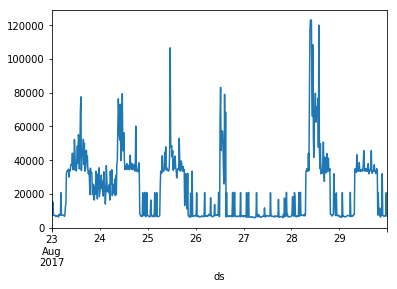

In [101]:
print("Start Day = {}, End Day = {}".format(start_day, last_day))
plot_start = pd.to_datetime(start_day)
plot_end = pd.to_datetime(last_day)
y_values[start_day:last_day].plot()

Modeling Holidays and Special Events

If you have holidays or other recurring events that you'd like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to included Christmas Eve in addition to Christmas you'd include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you'd include lower_window=0,upper_window=1. You can also include a column prior_scale to set the prior scale separately for each holiday.

Prior scale for holidays and seasonality

If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter holidays_prior_scale. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [102]:
# Include the days off as holidays.
# This will be all weekends and holidays....
saturdays = pd.DataFrame({'holiday': 'saturday', 'ds': pd.date_range(start='2017-05-06', end='2017-09-09', freq='7D')})
sundays = pd.DataFrame({'holiday': 'sunday', 'ds': pd.date_range(start='2017-05-06', end='2017-09-10', freq='7D')})
us_holidays = pd.DataFrame({'holiday': 'us_holidays', 'ds': pd.to_datetime(['2017-05-29', '2017-07-04', '2017-09-04']),
            'lower_window': [0, -1, 0], 'upper_window': 0})
holidays = pd.concat((saturdays, sundays, us_holidays))
holidays

,ds,holiday,lower_window,upper_window
0,2017-05-06,saturday,NaN,NaN
1,2017-05-13,saturday,NaN,NaN
2,2017-05-20,saturday,NaN,NaN
3,2017-05-27,saturday,NaN,NaN
4,2017-06-03,saturday,NaN,NaN
5,2017-06-10,saturday,NaN,NaN
6,2017-06-17,saturday,NaN,NaN
7,2017-06-24,saturday,NaN,NaN
8,2017-07-01,saturday,NaN,NaN
9,2017-07-08,saturday,NaN,NaN


In previous forecasts, we've only seen uncertainty in the future trend.  However, prophet does provide the ability to get uncertainty intervals around the trend, seasonality and holiday effects.  This requires Markov Chain Monte Carlo sampling.

The MCMC sampling takes additional time (minutes, instead of seconds), except (as I understand it) on Windows where there is a performance problem.  Therefore, on Windows, unless you have lots of compute power or time to spare, do not set the MCMC samples very high.

In [103]:
# On Windows, there is a performance problem.  Therefore, on Windows,
# don't set the number of Markov Chain, Monte Carlo samples very high,
# during development (unless you are willing to wait a long time for
# the results).
m1 = Prophet(yearly_seasonality=False, holidays=holidays, mcmc_samples=100)
m1.fit(df_data)

In [104]:
future1 = m1.make_future_dataframe(periods=7*24*4, freq='15T')
future1.head()

,ds
0,2017-05-02 00:00:00
1,2017-05-02 00:15:00
2,2017-05-02 00:30:00
3,2017-05-02 00:45:00
4,2017-05-02 01:00:00


In [105]:
forecast1 = m1.predict(future1)
forecast1.tail(8)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,holidays,...,sunday,sunday_lower,sunday_upper,us_holidays,us_holidays_lower,us_holidays_upper,weekly,weekly_lower,weekly_upper,yhat
12183,2017-09-05 22:00:00,27224.937856,26164.126259,28310.303788,4446.855056,36856.715310,-10197.037253,-10685.844163,-9776.729744,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3451.568358,3053.080320,3869.273750,20479.468960
12184,2017-09-05 22:15:00,27226.989160,26165.233521,28313.266438,4661.652579,37456.570453,-10292.455187,-10740.696076,-9872.806086,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3446.658040,3047.091677,3861.584059,20381.192014
12185,2017-09-05 22:30:00,27229.040464,26166.367449,28316.229087,4345.836180,36797.095048,-10343.117171,-10808.102684,-9922.262409,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3442.625988,3042.119581,3854.542863,20328.549281
12186,2017-09-05 22:45:00,27231.091768,26167.501377,28319.191736,3759.369036,36889.319303,-10360.103132,-10826.301234,-9924.688095,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3439.471780,3037.839645,3848.282423,20310.460416
12187,2017-09-05 23:00:00,27233.143072,26168.635305,28321.863372,5543.745961,36526.314671,-10352.537999,-10807.179043,-9923.173294,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3437.194089,3034.923920,3850.314269,20317.799163
12188,2017-09-05 23:15:00,27235.194377,26169.769233,28324.618613,4786.882826,37679.572257,-10327.555555,-10774.946383,-9864.976978,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3435.790691,3039.063062,3854.298430,20343.429512
12189,2017-09-05 23:30:00,27237.245681,26170.926950,28327.273211,3856.700037,35529.738830,-10290.453649,-10727.938590,-9847.534592,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3435.258472,3037.122079,3858.928654,20382.050503
12190,2017-09-05 23:45:00,27239.296985,26171.766448,28330.042175,4719.203030,36291.582842,-10245.004359,-10667.407021,-9793.846031,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,3435.593436,3041.949637,3864.198740,20429.886061


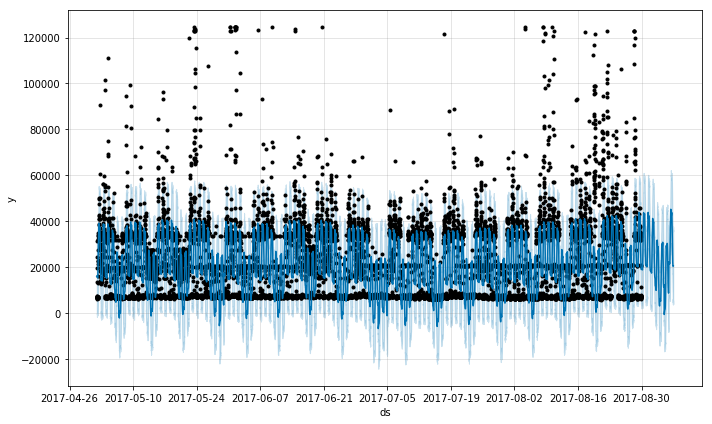

In [106]:
m1.plot(forecast1);

Now we get uncertainty estimates around the components of the forecast....


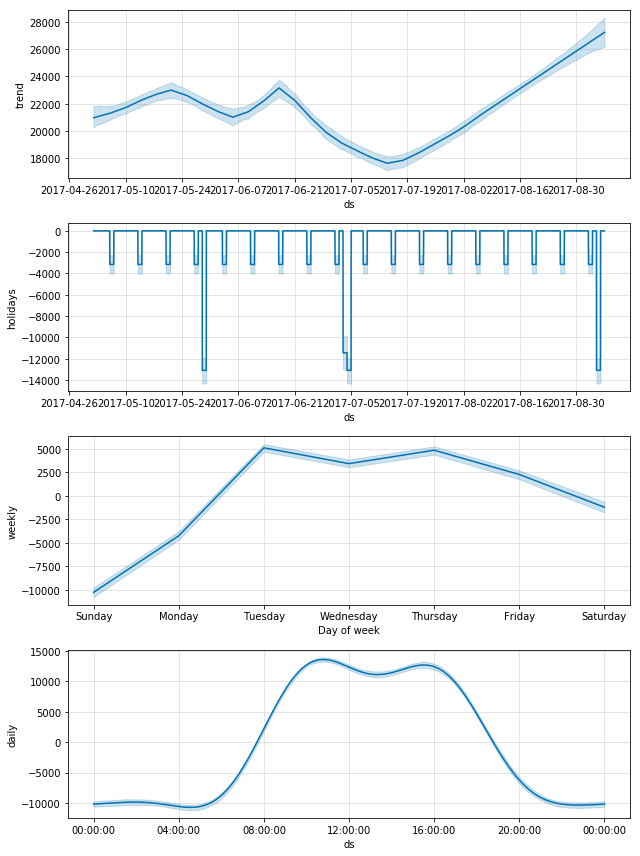

In [107]:
m1.plot_components(forecast1);

Entered calculate_residual_dataframe


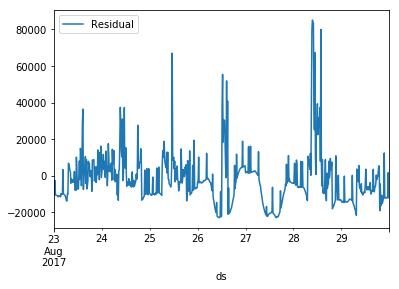

In [111]:
df_prophet_residual = calculate_residual_dataframe(df_data, forecast1.set_index('ds'))

predicted_data_start = pd.to_datetime('2017-08-23')
predicted_data_end = pd.to_datetime('2017-08-30')
predicted_data_indexer = ((predicted_data_start <= df_prophet_residual.index) & (df_prophet_residual.index < predicted_data_end))
df_prophet_residual = df_prophet_residual.loc[predicted_data_indexer,:]
df_prophet_residual.plot()

In [112]:
def rms_error(residuals):
    return np.sqrt(np.mean(residuals**2))

def mean_abs_error(residuals):
    return np.mean(np.abs(residuals))

prophet_residuals = df_prophet_residual.loc[:, 'Residual'].get_values()
prophet_rmse = rms_error(prophet_residuals)
prophet_mae = mean_abs_error(prophet_residuals)

In [113]:
print("Prophet MAE = {}".format(prophet_mae))

Prophet MAE = 10088.55945393479


In [114]:
print("Prophet RMSE = {}".format(prophet_rmse))

Prophet RMSE = 14471.903522662544
